In [25]:
import pandas as pd
import gymnasium as gym
import os
from ale_py import ALEInterface, roms
import time
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.optimizers import Adam
import random
from collections import deque
from keras import Input

In [2]:

env = gym.make("ALE/Frogger-v5", render_mode='human')

initial_state = env.reset()
while True:
    env.render()


    # Take a step (0: LEFT, 1: DOWN, 2: RIGHT, 3: UP)
    action = env.action_space.sample()
    new_state, reward, terminated, truncated, info = env.step(action)
    print(action)

    env.render()

time.sleep(5)

env.reset()
env.close()

NameError: name 'gym' is not defined

In [7]:
env = gym.make("ALE/Frogger-v5", render_mode='rgb_array')
initial_state = env.reset()

In [8]:
screenshot=env.render()

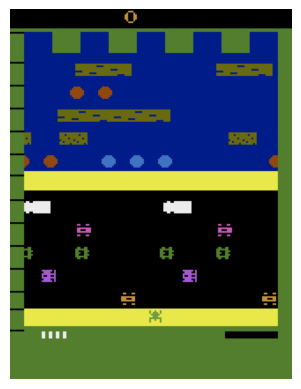

In [9]:
plt.imshow(screenshot)
plt.axis("off")
plt.show()

In [29]:
def gary(image):
    gar=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    crap=gar[12:-30, 7:-7]
    resized = cv2.resize(crap, (84, 84), interpolation=cv2.INTER_AREA)
    return resized 

In [30]:
pros=gary(screenshot)

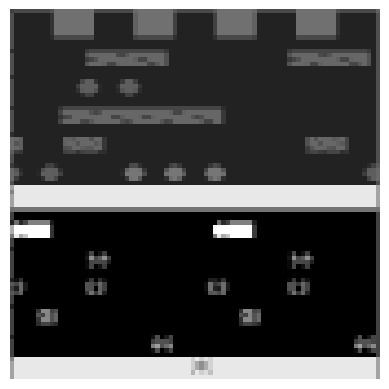

In [31]:
plt.imshow(pros,cmap='gray')
plt.axis("off")
plt.show()

In [32]:
def modl(input_shape, num_actions):
    model = Sequential([
        Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=input_shape),
        Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
        Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_actions, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

In [33]:
class DQNAgent:
    def __init__(self, action_size):
        self.memory = deque(maxlen=100000)
        self.action_size = action_size
        self.model = modl((84, 84, 1), action_size)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis, :, :, np.newaxis], verbose=0)
        return np.argmax(q_values[0])
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_q = np.max(self.model.predict(next_state[np.newaxis, :, :, np.newaxis], verbose=0)[0])
                target = reward + self.gamma * next_q
            q_values = self.model.predict(state[np.newaxis, :, :, np.newaxis], verbose=0)
            q_values[0][action] = target
            self.model.fit(state[np.newaxis, :, :, np.newaxis], q_values, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
env = gym.make("ALE/Frogger-v5", render_mode='rgb_array')
agent = DQNAgent(env.action_space.n)
bf=[]
br=0
be=0
episodes = 3000
for e in range(episodes):
    obs, _ = env.reset()
    env.step(env.action_space.sample())
    frame = screenshot
    state = pros
    total_reward = 0
    done = False
    fram=[]
    while not done:
        action = agent.act(state)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        fram.append(env.render())
        next_state = pros
        fram.append(screenshot)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print(f"Episode {e+1}: {total_reward}")
            if total_reward>br:
                br=total_reward
                bf=fram
            break
    if len(agent.memory) > 1000:
        agent.replay(32)
env.close()

Episode 1: 10.0
Episode 2: 7.0
Episode 3: 10.0
Episode 4: 11.0
Episode 5: 13.0
Episode 6: 10.0
Episode 7: 11.0
Episode 8: 8.0
Episode 9: 10.0
Episode 10: 13.0
Episode 11: 9.0
Episode 12: 7.0
Episode 13: 9.0
Episode 14: 13.0
Episode 15: 8.0
Episode 16: 13.0
Episode 17: 14.0
Episode 18: 13.0
Episode 19: 9.0
Episode 20: 11.0
Episode 21: 10.0
Episode 22: 10.0
Episode 23: 6.0
Episode 24: 13.0
Episode 25: 7.0
Episode 26: 10.0
Episode 27: 12.0
Episode 28: 8.0
Episode 29: 8.0
Episode 30: 14.0
Episode 31: 9.0
Episode 32: 5.0
Episode 33: 8.0
Episode 34: 8.0
Episode 35: 8.0
Episode 36: 10.0
Episode 37: 10.0
Episode 38: 8.0
Episode 39: 7.0
Episode 40: 10.0
Episode 41: 9.0
Episode 42: 19.0
Episode 43: 7.0
Episode 44: 10.0
Episode 45: 9.0
Episode 46: 8.0
Episode 47: 8.0
Episode 48: 10.0
Episode 49: 9.0
Episode 50: 8.0
Episode 51: 6.0
Episode 52: 8.0
Episode 53: 8.0
Episode 54: 9.0
Episode 55: 7.0
Episode 56: 7.0
Episode 57: 7.0
Episode 58: 13.0
Episode 59: 12.0
Episode 60: 6.0
Episode 61: 9.0
Episod

In [64]:
agent.model.save("model.h5")

In [ ]:
env = gym.make("ALE/Frogger-v5", render_mode='human')
agent = DQNAgent(env.action_space.n)
agent.model.load_weights("model.h5")
obs, _ = env.reset()
env.step(env.action_space.sample())
frame = screenshot
state = pros
done = False
total_reward = 0
while not done:
    action = agent.act(state)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = pros
    total_reward += reward
    frame
print(f"score: {total_reward}")
env.close()


In [66]:
env.close()